In [37]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Wed_Jun__2_19:15:15_PDT_2021
Cuda compilation tools, release 11.4, V11.4.48
Build cuda_11.4.r11.4/compiler.30033411_0
gcc (Ubuntu 9.3.0-17ubuntu1~20.04) 9.3.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [38]:
# install dependencies: (use cu111 because colab has CUDA 11.1)
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

# install mmcv-full thus we could use CUDA operators
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html

# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!pip install -e .

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html
Cloning into 'mmdetection'...
remote: Enumerating objects: 32423, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 32423 (delta 23), reused 41 (delta 8), pack-reused 32338
Receiving objects: 100% (32423/32423), 41.93 MiB | 29.70 MiB/s, done.
Resolving deltas: 100% (23313/23313), done.
/aiffel/mmdetection/mmdetection/mmdetection
Obtaining file:///aiffel/mmdetection/mmdetection/mmdetection
  Preparing metadata (setup.py) ... done
  Attempting uninstall: mmdet
    Found existing installation: mmdet 2.25.3
    Uninstalling mmdet-2.25.3:
      Successfully uninstalled mmdet-2.25.3
  Running setup.py develop for mmdet


In [39]:
from mmcv import collect_env
collect_env()

{'sys.platform': 'linux',
 'Python': '3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:20:46) [GCC 9.4.0]',
 'CUDA available': True,
 'GPU 0': 'Tesla T4',
 'CUDA_HOME': '/opt/conda',
 'NVCC': 'Cuda compilation tools, release 11.4, V11.4.48',
 'GCC': 'gcc (Ubuntu 9.3.0-17ubuntu1~20.04) 9.3.0',
 'PyTorch': '1.9.0+cu111',
 'PyTorch compiling details': 'PyTorch built with:\n  - GCC 7.3\n  - C++ Version: 201402\n  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications\n  - Intel(R) MKL-DNN v2.1.2 (Git Hash 98be7e8afa711dc9b66c8ff3504129cb82013cdb)\n  - OpenMP 201511 (a.k.a. OpenMP 4.5)\n  - NNPACK is enabled\n  - CPU capability usage: AVX2\n  - CUDA Runtime 11.1\n  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_80;-gencode;arch=compu

In [40]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.9.0+cu111 True
2.25.3
11.1
GCC 7.3


**Perform Inference with An MMDet detector**

In [41]:
# We download the pre-trained checkpoints for inference and finetuning.
!mkdir checkpoints
!wget -c https://download.openmmlab.com/mmclassification/v0/efficientnet/efficientnet-b3_3rdparty_8xb32-aa_in1k_20220119-5b4887a0.pth \
      -O checkpoints//efficientnet-b3_3rdparty_8xb32-aa_in1k_20220119-5b4887a0.pth

--2022-11-16 06:55:36--  https://download.openmmlab.com/mmclassification/v0/efficientnet/efficientnet-b3_3rdparty_8xb32-aa_in1k_20220119-5b4887a0.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.88.36.86
Connecting to download.openmmlab.com (download.openmmlab.com)|47.88.36.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49397898 (47M) [application/octet-stream]
Saving to: ‘checkpoints//efficientnet-b3_3rdparty_8xb32-aa_in1k_20220119-5b4887a0.pth’

checkpoints//effici 100%[===================>]  47.11M  12.3MB/s    in 4.2s    

2022-11-16 06:55:41 (11.2 MB/s) - ‘checkpoints//efficientnet-b3_3rdparty_8xb32-aa_in1k_20220119-5b4887a0.pth’ saved [49397898/49397898]



In [42]:
import mmcv
from mmcv.runner import load_checkpoint

from mmdet.apis import inference_detector, show_result_pyplot
from mmdet.models import build_detector

# Choose to use a config and initialize the detector
config = 'configs/efficientnet/retinanet_effb3_fpn_crop896_8x4_1x_coco.py'
# Setup a checkpoint file to load
checkpoint = 'checkpoints/efficientnet-b3_3rdparty_8xb32-aa_in1k_20220119-5b4887a0.pth'

# Set the device to be used for evaluation
device='cuda:0'

# Load the config
config = mmcv.Config.fromfile(config)
# Set pretrained to be None since we do not need pretrained model here
config.model.pretrained = None

# Initialize the detector
model = build_detector(config.model)

# Load checkpoint
checkpoint = load_checkpoint(model, checkpoint, map_location=device)

# Set the classes of models for inference
model.CLASSES = checkpoint['meta']['CLASSES']

# We need to set the model's cfg for inference
model.cfg = config

# Convert the model to GPU
model.to(device)
# Convert the model into evaluation mode
model.eval()

load checkpoint from local path: checkpoints/efficientnet-b3_3rdparty_8xb32-aa_in1k_20220119-5b4887a0.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: head.fc.weight, head.fc.bias, backbone.layers.6.bn.running_var, backbone.layers.6.bn.running_mean, backbone.layers.6.bn.weight, backbone.layers.6.bn.bias, backbone.layers.6.conv.weight

missing keys in source state_dict: neck.lateral_convs.0.conv.weight, neck.lateral_convs.0.conv.bias, neck.lateral_convs.1.conv.weight, neck.lateral_convs.1.conv.bias, neck.lateral_convs.2.conv.weight, neck.lateral_convs.2.conv.bias, neck.fpn_convs.0.conv.weight, neck.fpn_convs.0.bn.weight, neck.fpn_convs.0.bn.bias, neck.fpn_convs.0.bn.running_mean, neck.fpn_convs.0.bn.running_var, neck.fpn_convs.1.conv.weight, neck.fpn_convs.1.bn.weight, neck.fpn_convs.1.bn.bias, neck.fpn_convs.1.bn.running_mean, neck.fpn_convs.1.bn.running_var, neck.fpn_convs.2.conv.weight, neck.fpn_convs.2.bn.weight, neck.fpn_convs.2.bn.bias

RetinaNet(
  (backbone): EfficientNet(
    (layers): ModuleList(
      (0): ConvModule(
        (conv): Conv2dAdaptivePadding(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): SyncBatchNorm(40, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (activate): Swish()
      )
      (1): Sequential(
        (0): InvertedResidual(
          (drop_path): Identity()
          (depthwise_conv): ConvModule(
            (conv): Conv2dAdaptivePadding(40, 40, kernel_size=(3, 3), stride=(1, 1), groups=40, bias=False)
            (bn): SyncBatchNorm(40, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (activate): Swish()
          )
          (se): SELayer(
            (global_avgpool): AdaptiveAvgPool2d(output_size=1)
            (conv1): ConvModule(
              (conv): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
              (activate): Swish()
            )
            (conv2): ConvModule(
              (conv): Conv2d(10,

**Inference the detector**

In [43]:
# Use the detector to do inference
img = 'demo/demo.jpg'
result = inference_detector(model, img)

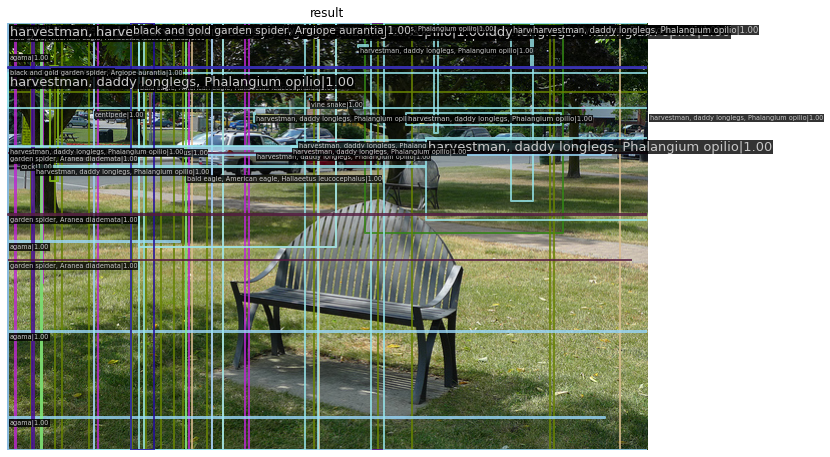

In [44]:
# Let's plot the result
show_result_pyplot(model, img, result, score_thr=0.3)

**Train A Detector on A Customized Dataset**

In [45]:
# download, decompress the data
!wget https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip
!unzip kitti_tiny.zip > /dev/null

--2022-11-16 06:55:45--  https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip
Resolving download.openmmlab.com (download.openmmlab.com)... 47.88.36.86
Connecting to download.openmmlab.com (download.openmmlab.com)|47.88.36.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6918271 (6.6M) [application/zip]
Saving to: ‘kitti_tiny.zip’

kitti_tiny.zip      100%[===================>]   6.60M  11.5MB/s    in 0.6s    

2022-11-16 06:55:51 (11.5 MB/s) - ‘kitti_tiny.zip’ saved [6918271/6918271]



In [46]:
# Check the directory structure of the tiny data

# Install tree first
!apt-get -q install tree
!tree kitti_tiny

Reading package lists...
Building dependency tree...
Reading state information...
tree is already the newest version (1.8.0-1).
The following packages were automatically installed and are no longer required:
  accountsservice-ubuntu-schemas bc bluez-obexd cups cups-browsed cups-client
  cups-common cups-core-drivers cups-daemon cups-filters
  cups-filters-core-drivers cups-ipp-utils cups-ppdc cups-server-common
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript
  gir1.2-dbusmenu-glib-0.4 gnome-bluetooth gnome-power-manager
  gnome-screensaver gsettings-ubuntu-schemas gvfs-backends indicator-applet
  indicator-application indicator-appmenu indicator-bluetooth indicator-common
  indicator-datetime indicator-keyboard indicator-messages indicator-power
  indicator-printers indicator-session indicator-sound jayatana
  libaccounts-glib0 libbamf3-2 libcdio-cdda2 libcdio-paranoia2 libcdio18
  libcupsfilters1 libfcitx-config4 libfcitx-gclient1 libfcitx-utils0
  libfontembed1 li

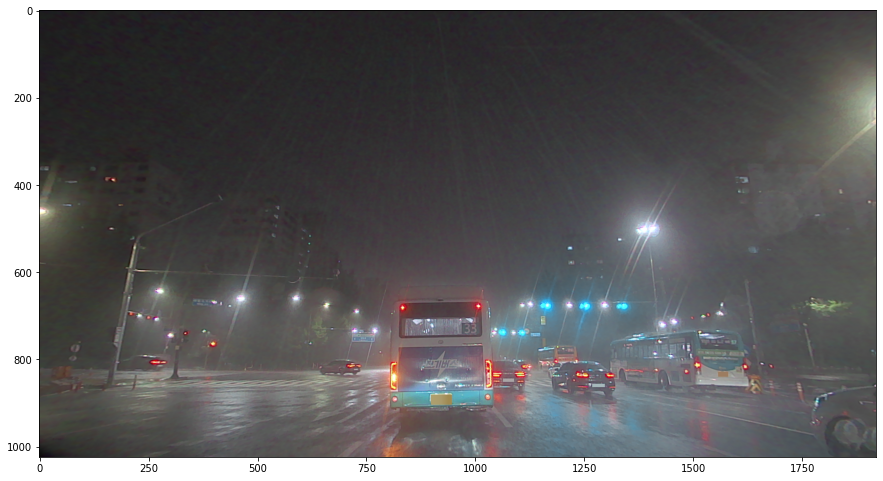

In [47]:
# Let's take a look at the dataset image
import mmcv
import matplotlib.pyplot as plt
import os

HOME_DIR = os.getenv('HOME')
img = mmcv.imread(HOME_DIR+'/aiffel/aimmo/image/1659964852731_FR-View-CMR-Wide.jpg')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [48]:
# Check the label of a single image
!cat aimmo/annotation/1659964852731_FR-View-CMR-Wide_Bbox_GT.json

cat: aimmo/annotation/1659964852731_FR-View-CMR-Wide_Bbox_GT.json: No such file or directory


In [49]:
import copy
import os.path as osp

import mmcv
import numpy as np

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

@DATASETS.register_module()
class AimmoEfficientnet1Dataset(CustomDataset):

    CLASSES = ('Car', 'Pedestrian', 'Cyclist')

    def load_annotations(self, ann_file):
        cat2label = {k: i for i, k in enumerate(self.CLASSES)}
        # load image list from file
        image_list = mmcv.list_from_file(self.ann_file)
    
        data_infos = []
        # convert annotations to middle format
        for image_id in image_list:
            filename = f'{self.img_prefix}/{image_id}.jpg'
            image = mmcv.imread(filename)
            height, width = image.shape[:2]
    
            data_info = dict(filename=f'{image_id}.jpg', width=width, height=height)
    
            # load annotations
            label_prefix = self.img_prefix.replace('image', 'annotation')
            lines = mmcv.list_from_file(osp.join(label_prefix, f'{image_id}.json'))
    
            content = [line.strip().split(' ') for line in lines]
            bbox_names = [x[0] for x in content]
            bboxes = [[float(info) for info in x[4:8]] for x in content]
    
            gt_bboxes = []
            gt_labels = []
            gt_bboxes_ignore = []
            gt_labels_ignore = []
    
            # filter 'DontCare'
            for bbox_name, bbox in zip(bbox_names, bboxes):
                if bbox_name in cat2label:
                    gt_labels.append(cat2label[bbox_name])
                    gt_bboxes.append(bbox)
                else:
                    gt_labels_ignore.append(-1)
                    gt_bboxes_ignore.append(bbox)

            data_anno = dict(
                bboxes=np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
                labels=np.array(gt_labels, dtype=np.long),
                bboxes_ignore=np.array(gt_bboxes_ignore,
                                       dtype=np.float32).reshape(-1, 4),
                labels_ignore=np.array(gt_labels_ignore, dtype=np.long))

            data_info.update(ann=data_anno)
            data_infos.append(data_info)

        return data_infos

KeyError: 'AimmoEfficientnet1Dataset is already registered in dataset'

**Modify the config**

In [50]:
from mmcv import Config
cfg = Config.fromfile(HOME_DIR+'/mmdetection/configs/efficientnet/retinanet_effb3_fpn_crop896_8x4_1x_coco.py')


**Train a new detector**

In [51]:
from mmdet.apis import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'AimmoEfficientnet1Dataset'
cfg.data_root = HOME_DIR+'/aiffel/aimmo/'

cfg.data.test.type = 'AimmoEfficientnet1Dataset'
cfg.data.test.data_root = HOME_DIR+'/aiffel/aimmo/'
cfg.data.test.ann_file = '1659964864459_FR-View-CMR-Wide_Bbox_GT.json'
cfg.data.test.img_prefix = 'image'

cfg.data.train.type = 'AimmoEfficientnet1Dataset'
cfg.data.train.data_root = HOME_DIR+'/aiffel/aimmo/'
cfg.data.train.ann_file = '1659964864459_FR-View-CMR-Wide_Bbox_GT.json'
cfg.data.train.img_prefix = 'image'

cfg.data.val.type = 'AimmoEfficientnet1Dataset'
cfg.data.val.data_root = HOME_DIR+'/aiffel/aimmo/'
cfg.data.val.ann_file = '1659964865459_FR-View-CMR-Wide_Bbox_GT.json'
cfg.data.val.img_prefix = 'image'

# modify num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = 3
# If we need to finetune a model based on a pre-trained detector, we need to
# use load_from to set the path of checkpoints.
cfg.load_from = 'checkpoints/efficientnet-b3_3rdparty_8xb32-aa_in1k_20220119-5b4887a0.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# We can also use tensorboard to log the training process
cfg.log_config.hooks = [
    dict(type='TextLoggerHook'),
    dict(type='TensorboardLoggerHook')]


# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')


AttributeError: 'ConfigDict' object has no attribute 'roi_head'

In [52]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
cfg.device='cuda'
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

FileNotFoundError: AimmoEfficientnet1Dataset: [Errno 2] No such file or directory: '/aiffel/aiffel/aimmo/image/{.jpg'

**Understand the log**

In [53]:
# load tensorboard in colab
%load_ext tensorboard

# see curves in tensorboard
%tensorboard --logdir ./tutorial_exps

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


**Test the Trained Detector**

/aiffel/mmdetection/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(


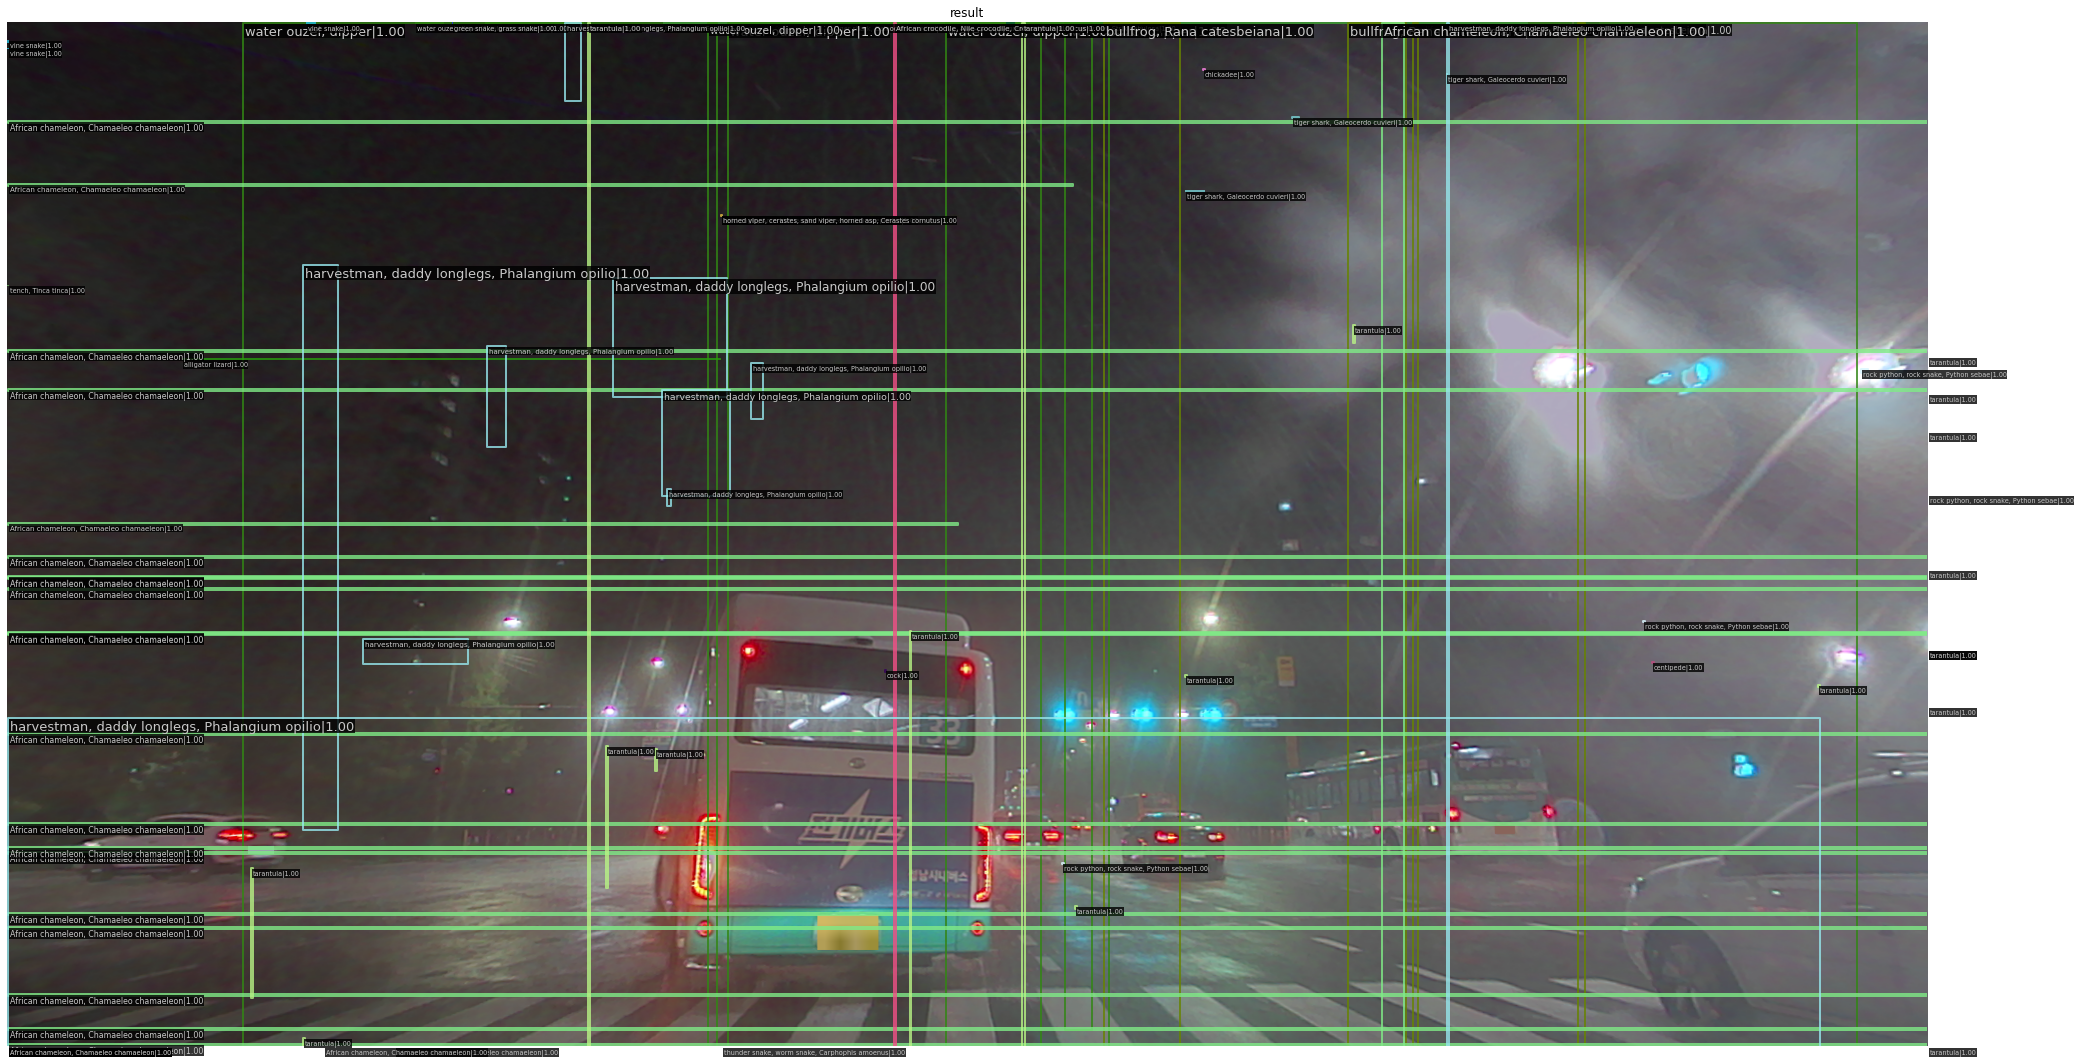

In [54]:
img = mmcv.imread(HOME_DIR+'/aiffel/aimmo/image/1659964856829_FR-View-CMR-Wide.jpg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)